In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Reshape, Activation, Dropout, Input, BatchNormalization, Conv1D, SeparableConv1D
from keras.layers import Conv2D, Flatten, AveragePooling1D, AveragePooling2D, Concatenate, Embedding, LSTM
from keras.layers import add, concatenate, MaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
def training_set():
    (X, Y), _ = mnist.load_data()
    X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))   
    Y = np_utils.to_categorical(Y)
    return X, Y

def validation_set():
    _, (X, Y) = mnist.load_data()
    X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))   
    Y = np_utils.to_categorical(Y)
    return X, Y

In [3]:
X, Y = training_set()
X_val, Y_val = validation_set()

In [4]:
print(X.shape)
print(Y.shape)
print(X_val.shape)
print(Y_val.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [5]:
def input_block(block_input):
    base_input = Input(shape=block_input)
    return base_input

In [6]:
def base_block(block_input):
    dense32 = Dense(2**5)(block_input)
    return dense32

In [7]:
input_layer = input_block((X.shape[1],))
layer1out = base_block(input_layer)
layer2out = base_block(input_layer)
layer3out = base_block(input_layer)
layer4out = base_block(input_layer)

In [8]:
layer1out.shape

TensorShape([Dimension(None), Dimension(32)])

In [9]:
def block01(b1_input, b2_input):

    base_input = b1_input
    block_input = b2_input
    
    concat01 = concatenate([base_input,block_input])
    r1 = Reshape((2**3,2**3),input_shape=(2**6,))(concat01)    
    pool01 = MaxPooling1D()(r1)
    
    conv03 = Conv1D(2**3, 1+2**1, padding='same', activation='relu')(pool01)
    conv13 = Conv1D(2**3, 1+2**1, padding='same', activation='relu')(conv03)
    conv23 = Conv1D(2**3, 1+2**1, padding='same', activation='relu')(conv13)

    dense01 = Dense(2**3, activation='relu')(pool01)

    concat01 = concatenate([conv23, dense01])
    flatten01 = Flatten()(concat01)
    dropout01 = Dropout(2**5/2**7)(flatten01)
    dense02 = Dense(2**4)(dropout01)
    batchnorm01 = BatchNormalization(axis=-1)(dense02)
    
    return batchnorm01

In [10]:
def block4i(b1_input, b2_input, b3_input, b4_input):

    concat01 = concatenate([b1_input, b2_input, b3_input, b4_input])
    r1 = Reshape((2**3,2**3),input_shape=(2**6,))(concat01)    
    pool01 = MaxPooling1D()(r1)
    
    conv03 = Conv1D(2**3, 1+2**1, padding='same', activation='relu')(pool01)
    conv13 = Conv1D(2**3, 1+2**1, padding='same', activation='relu')(conv03)
    conv23 = Conv1D(2**3, 1+2**1, padding='same', activation='relu')(conv13)

    dense01 = Dense(2**3, activation='relu')(pool01)

    concat01 = concatenate([conv23, dense01])
    flatten01 = Flatten()(concat01)
    dropout01 = Dropout(2**5/2**7)(flatten01)
    dense02 = Dense(2**4)(dropout01)
    batchnorm01 = BatchNormalization(axis=-1)(dense02)
    
    return batchnorm01

In [19]:
layers = []
layers.append(block01(layer1out, layer2out))
layers.append(block01(layer2out, layer3out))
layers.append(block01(layer3out, layer4out))
layers.append(block01(layer4out, layer1out))

for i in range(3, 20):
    layer = block4i(layers[i-3], layers[i-2], layers[i-1], layers[i])
    layers.append(layer)
finallayer = Dense(10, activation='sigmoid')(layers[-1])

In [20]:
model = Model(inputs=[input_layer], outputs = finallayer)

In [ ]:
model.summary()

In [21]:
opt = Adam(lr=0.0003)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [25]:
history = model.fit(X, Y, batch_size = 2**10, epochs=40, initial_epoch=0, validation_data=(X_val,Y_val))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 14s 236us/step - loss: 0.0077 - acc: 0.9985 - val_loss: 0.0268 - val_acc: 0.9950
Epoch 2/40
60000/60000 [==============================] - 14s 232us/step - loss: 0.0074 - acc: 0.9985 - val_loss: 0.0284 - val_acc: 0.9948
Epoch 3/40
60000/60000 [==============================] - 14s 235us/step - loss: 0.0077 - acc: 0.9985 - val_loss: 0.0282 - val_acc: 0.9948
Epoch 4/40
60000/60000 [==============================] - 16s 261us/step - loss: 0.0076 - acc: 0.9985 - val_loss: 0.0288 - val_acc: 0.9947
Epoch 5/40
60000/60000 [==============================] - 16s 263us/step - loss: 0.0078 - acc: 0.9984 - val_loss: 0.0291 - val_acc: 0.9946
Epoch 6/40
60000/60000 [==============================] - 16s 261us/step - loss: 0.0076 - acc: 0.9985 - val_loss: 0.0289 - val_acc: 0.9947
Epoch 7/40
60000/60000 [==============================] - 16s 260us/step - loss: 0.0078 - acc: 0.9984 - val_loss: 0.

In [ ]:
Yp = np_utils.to_categorical(np.argmax(model.predict(X), 1))
acc = 1 - np.average(np.abs(Yp-Y))
print(acc)

In [ ]:
Yp_val = np_utils.to_categorical(np.argmax(model.predict(X_val), 1))
print(Yp_val.shape)
acc1 = 1 - np.average(np.abs(Yp_val-Y_val))
print(acc1)

In [ ]:
loss, acc = model.evaluate(X, Y)
print("Accuracy = ", acc)
print("Logloss = ", loss)

In [ ]:
loss_val, acc_val = model.evaluate(X_val, Y_val)
print("Accuracy = ", acc_val)
print("Logloss = ", loss_val)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


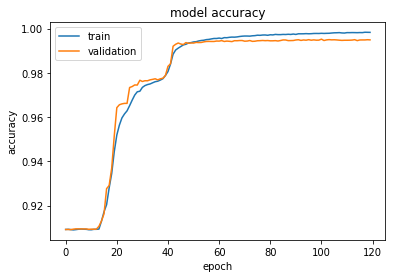

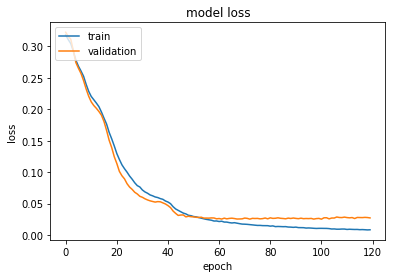

In [24]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
Yp = np_utils.to_categorical(np.argmax(model.predict(X), 1))

In [ ]:
for i in range(0,10):
    print("Example numero: ", i)
    print(yp[i])
    print(ypo[i])

In [ ]:
ypo.shape

In [ ]:
ypredict[1]